In [1]:
import numpy as np
import pandas as pd

import scipy
from scipy.cluster.hierarchy import dendrogram,linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sb

import sklearn
# from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm
from sklearn.preprocessing import scale

In [2]:
# Configure the output
np.set_printoptions(precision=4,suppress=True)
%matplotlib inline
rcParams["figure.figsize"] =20,10
sb.set_style("whitegrid")

In [3]:
df = pd.read_csv('../data/example.csv')
df.head()

,Unnamed: 0,first,second,score
0,0,"People with Virgo rising tend to be practical,...","You have an ingenious, active and alert mind.",2
1,1,"People with Virgo rising tend to be practical,...",Gaining knowledge and putting it to good use a...,3
2,2,"People with Virgo rising tend to be practical,...",You strive for perfection and can be quite the...,3
3,3,"People with Virgo rising tend to be practical,...","At times others can never be ""good"" enough to ...",3
4,4,"People with Virgo rising tend to be practical,...",Finding fault with what's wrong with things is...,3


In [4]:
df = df.drop(columns=['Unnamed: 0'])

In [5]:
df.head()

,first,second,score
0,"People with Virgo rising tend to be practical,...","You have an ingenious, active and alert mind.",2
1,"People with Virgo rising tend to be practical,...",Gaining knowledge and putting it to good use a...,3
2,"People with Virgo rising tend to be practical,...",You strive for perfection and can be quite the...,3
3,"People with Virgo rising tend to be practical,...","At times others can never be ""good"" enough to ...",3
4,"People with Virgo rising tend to be practical,...",Finding fault with what's wrong with things is...,3


In [6]:
df.describe()

,first,second,score
count,1830,1830,1830
unique,60,60,10
top,"People with Virgo rising tend to be practical,...",More about,5
freq,60,60,1488


In [7]:
df_clean = df.dropna()

In [8]:
df_clean.describe()

,first,second,score
count,1830,1830,1830
unique,60,60,10
top,"People with Virgo rising tend to be practical,...",More about,5
freq,60,60,1488


In [9]:
df.dtypes

first     object
second    object
score     object
dtype: object

In [10]:
# as score was of object type, the 'na' values were not dropped.

In [11]:
df_clean = df.loc[df['score'] != 'na']
df_clean.describe()

,first,second,score
count,1770,1770,1770
unique,59,59,9
top,"People with Virgo rising tend to be practical,...",You aim to please in practical and earthy ways.,5
freq,59,59,1488


In [12]:
df_clean.dtypes

first     object
second    object
score     object
dtype: object

In [13]:
df_clean = df_clean.copy()
df_clean['dist'] = df_clean['score'].astype(int)
df_clean.head()

,first,second,score,dist
0,"People with Virgo rising tend to be practical,...","You have an ingenious, active and alert mind.",2,2
1,"People with Virgo rising tend to be practical,...",Gaining knowledge and putting it to good use a...,3,3
2,"People with Virgo rising tend to be practical,...",You strive for perfection and can be quite the...,3,3
3,"People with Virgo rising tend to be practical,...","At times others can never be ""good"" enough to ...",3,3
4,"People with Virgo rising tend to be practical,...",Finding fault with what's wrong with things is...,3,3


In [14]:
df_clean.dtypes

first     object
second    object
score     object
dist       int32
dtype: object

In [15]:
df_clean = df_clean.drop(columns=['score'])
df_clean.head()

,first,second,dist
0,"People with Virgo rising tend to be practical,...","You have an ingenious, active and alert mind.",2
1,"People with Virgo rising tend to be practical,...",Gaining knowledge and putting it to good use a...,3
2,"People with Virgo rising tend to be practical,...",You strive for perfection and can be quite the...,3
3,"People with Virgo rising tend to be practical,...","At times others can never be ""good"" enough to ...",3
4,"People with Virgo rising tend to be practical,...",Finding fault with what's wrong with things is...,3


In [16]:
df_clean.describe()

,dist
count,1770.000000
mean,4.719774
std,0.814998
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,9.000000


In [17]:
# convert this original dataframe to a 'square' distance matrix.
# we utilise a pivot table to do this

# first, add the redundant pairs (two of the same sentences) to the data.
# we need this for the pivot function to generate the correct rows and columns.
first = np.unique(df_clean['first'].values)
second = np.unique(df_clean['second'].values)
combined_arr = np.concatenate((first, second))
sentences = np.unique(combined_arr)
print(len(sentences))

60


In [18]:
add_data = np.column_stack([sentences, sentences, np.zeros(len(sentences))])
print(add_data)

[['Anyone who lives with you must accept your ups and downs and appreciate your need for times of withdrawal.'
  'Anyone who lives with you must accept your ups and downs and appreciate your need for times of withdrawal.'
  0.0]
 ['At times others can never be "good" enough to meet those high standards.'
  'At times others can never be "good" enough to meet those high standards.'
  0.0]
 ['At times you can be lazy, hoping or expecting someone else to do the dirty work.'
  'At times you can be lazy, hoping or expecting someone else to do the dirty work.'
  0.0]
 ['At times you can be very indecisive and unsure.'
  'At times you can be very indecisive and unsure.' 0.0]
 ['Comfort is important to you and you hate getting your hands dirty.'
  'Comfort is important to you and you hate getting your hands dirty.'
  0.0]
 ['Control of thought, word, and action is necessary in order to be successful.'
  'Control of thought, word, and action is necessary in order to be successful.'
  0.0]
 ['Deb

In [19]:
add_df = pd.DataFrame(data=add_data, columns=df_clean.columns)
add_df.head()

,first,second,dist
0,Anyone who lives with you must accept your ups...,Anyone who lives with you must accept your ups...,0
1,"At times others can never be ""good"" enough to ...","At times others can never be ""good"" enough to ...",0
2,"At times you can be lazy, hoping or expecting ...","At times you can be lazy, hoping or expecting ...",0
3,At times you can be very indecisive and unsure.,At times you can be very indecisive and unsure.,0
4,Comfort is important to you and you hate getti...,Comfort is important to you and you hate getti...,0


In [20]:
df_clean = df_clean.append(add_df, ignore_index=True)
df_clean.head()

,first,second,dist
0,"People with Virgo rising tend to be practical,...","You have an ingenious, active and alert mind.",2
1,"People with Virgo rising tend to be practical,...",Gaining knowledge and putting it to good use a...,3
2,"People with Virgo rising tend to be practical,...",You strive for perfection and can be quite the...,3
3,"People with Virgo rising tend to be practical,...","At times others can never be ""good"" enough to ...",3
4,"People with Virgo rising tend to be practical,...",Finding fault with what's wrong with things is...,3


In [21]:
df_clean.describe()

,first,second,dist
count,1830,1830,1830.0
unique,60,60,10.0
top,"People with Virgo rising tend to be practical,...",You aim to please in practical and earthy ways.,5.0
freq,60,60,1488.0


In [22]:
df_piv = df_clean.pivot("first", "second", "dist").fillna(0)
piv_arr = df_piv.values
dist_mat = piv_arr + np.transpose(piv_arr)

In [23]:
df_piv.describe()

second,Anyone who lives with you must accept your ups and downs and appreciate your need for times of withdrawal.,"At times others can never be ""good"" enough to meet those high standards.","At times you can be lazy, hoping or expecting someone else to do the dirty work.",At times you can be very indecisive and unsure.,Comfort is important to you and you hate getting your hands dirty.,"Control of thought, word, and action is necessary in order to be successful.",Debate and argument appeal to you.,Exercise is a good way to release this tension.,"Find your focus, stay with it and develop perseverance.",Finding fault with what's wrong with things is your forte.,...,You often appear irrational to others because you can't always explain the reason or source of your feelings.,"You seek knowledge, either through reading or conversation, or through travel and talking with the new people you constantly meet.",You soak up feelings like a sponge.,You strive for perfection and can be quite the person to live with or to be around because your standards for yourself and others are so high.,"You take slights very personally and though you may forgive a mistake by a friend or loved one, you never forget it.",You tend to be a pack-rat because everything has an emotional memory behind it and you find security in all those memories.,"You tend to look younger than you really are, no matter what your age.",Your greatest need is to nurture and mother someone or ones.,Your mother is/was a strong influence for good or ill in your life.,Your senses and emotions are quite strong and it would be wise for you to listen to your intuitive side as you can be quite psychic.
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.00000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.00000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,1.566667,0.233333,4.616667,1.100000,4.483333,3.550000,3.30000,2.850000,3.683333,0.250000,...,1.450000,2.750000,1.216667,0.216667,1.70000,2.400000,1.000000,1.550000,2.216667,1.966667
std,2.212190,0.980603,1.276803,2.031114,1.443767,2.070167,2.27216,2.420429,2.205476,0.985058,...,2.118722,2.467586,2.108029,0.975838,2.24967,2.505587,2.016878,2.302725,2.484472,2.435380
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,5.000000,0.000000,5.000000,2.750000,0.00000,0.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,5.000000,0.000000,5.000000,5.000000,5.00000,5.000000,5.000000,0.000000,...,0.000000,5.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,0.000000,5.000000,0.000000,5.000000,5.000000,5.00000,5.000000,5.000000,0.000000,...,4.000000,5.000000,1.500000,0.000000,5.00000,5.000000,0.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,9.000000,5.000000,...,6.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,6.000000


In [24]:
for i in range(len(dist_mat)):
    print(dist_mat[i][i])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [25]:
from scipy.spatial.distance import squareform
condensed_mat = squareform(dist_mat)

In [26]:
df_piv.index == df_piv.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [27]:
linkage_arr = linkage(condensed_mat)

In [28]:
linkage_arr

array([[ 25.,  26.,   1.,   2.],
       [ 27.,  60.,   1.,   3.],
       [ 36.,  61.,   1.,   4.],
       [ 41.,  62.,   1.,   5.],
       [ 45.,  63.,   1.,   6.],
       [ 46.,  64.,   1.,   7.],
       [ 12.,  42.,   1.,   2.],
       [  1.,   9.,   1.,   2.],
       [ 21.,  67.,   1.,   3.],
       [ 24.,  68.,   1.,   4.],
       [ 53.,  69.,   1.,   5.],
       [ 47.,  70.,   1.,   6.],
       [  7.,  43.,   1.,   2.],
       [ 14.,  20.,   1.,   2.],
       [ 52.,  73.,   1.,   3.],
       [ 31.,  59.,   1.,   2.],
       [  0.,  22.,   2.,   2.],
       [ 50.,  76.,   2.,   3.],
       [  8.,  65.,   2.,   8.],
       [ 66.,  78.,   2.,  10.],
       [ 17.,  79.,   2.,  11.],
       [ 19.,  80.,   2.,  12.],
       [  6.,  81.,   2.,  13.],
       [ 71.,  82.,   2.,  19.],
       [ 29.,  83.,   2.,  20.],
       [  5.,  84.,   2.,  21.],
       [ 33.,  85.,   2.,  22.],
       [ 38.,  86.,   2.,  23.],
       [ 72.,  87.,   2.,  25.],
       [ 49.,  88.,   2.,  26.],
       [ 7

{'icoord': [[85.0, 85.0, 95.0, 95.0],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [125.0, 125.0, 142.5, 142.5],
  [175.0, 175.0, 185.0, 185.0],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [285.0, 285.0, 295.0, 295.0],
  [275.0, 275.0, 290.0, 290.0],
  [315.0, 315.0, 325.0, 325.0],
  [415.0, 415.0, 425.0, 425.0],
  [405.0, 405.0, 420.0, 420.0],
  [395.0, 395.0, 412.5, 412.5],
  [385.0, 385.0, 403.75, 403.75],
  [375.0, 375.0, 394.375, 394.375],
  [465.0, 465.0, 475.0, 475.0],
  [545.0, 545.0, 555.0, 555.0],
  [535.0, 535.0, 550.0, 550.0],
  [525.0, 525.0, 542.5, 542.5],
  [515.0, 515.0, 533.75, 533.75],
  [505.0, 505.0, 524.375, 524.375],
  [495.0, 495.0, 514.6875, 514.6875],
  [485.0, 485.0, 504.84375, 504.84375],
  [470.0, 470.0, 494.921875, 494.921875],
  [455.0, 455.0, 482.4609375, 482.4609375],
  [445.0, 445.0, 468.73046875, 468.73046875],
  [435.0, 435.0, 456.865234375, 456.865234375],
  [384.6875, 384.6875, 445.9326171875, 445.932617187

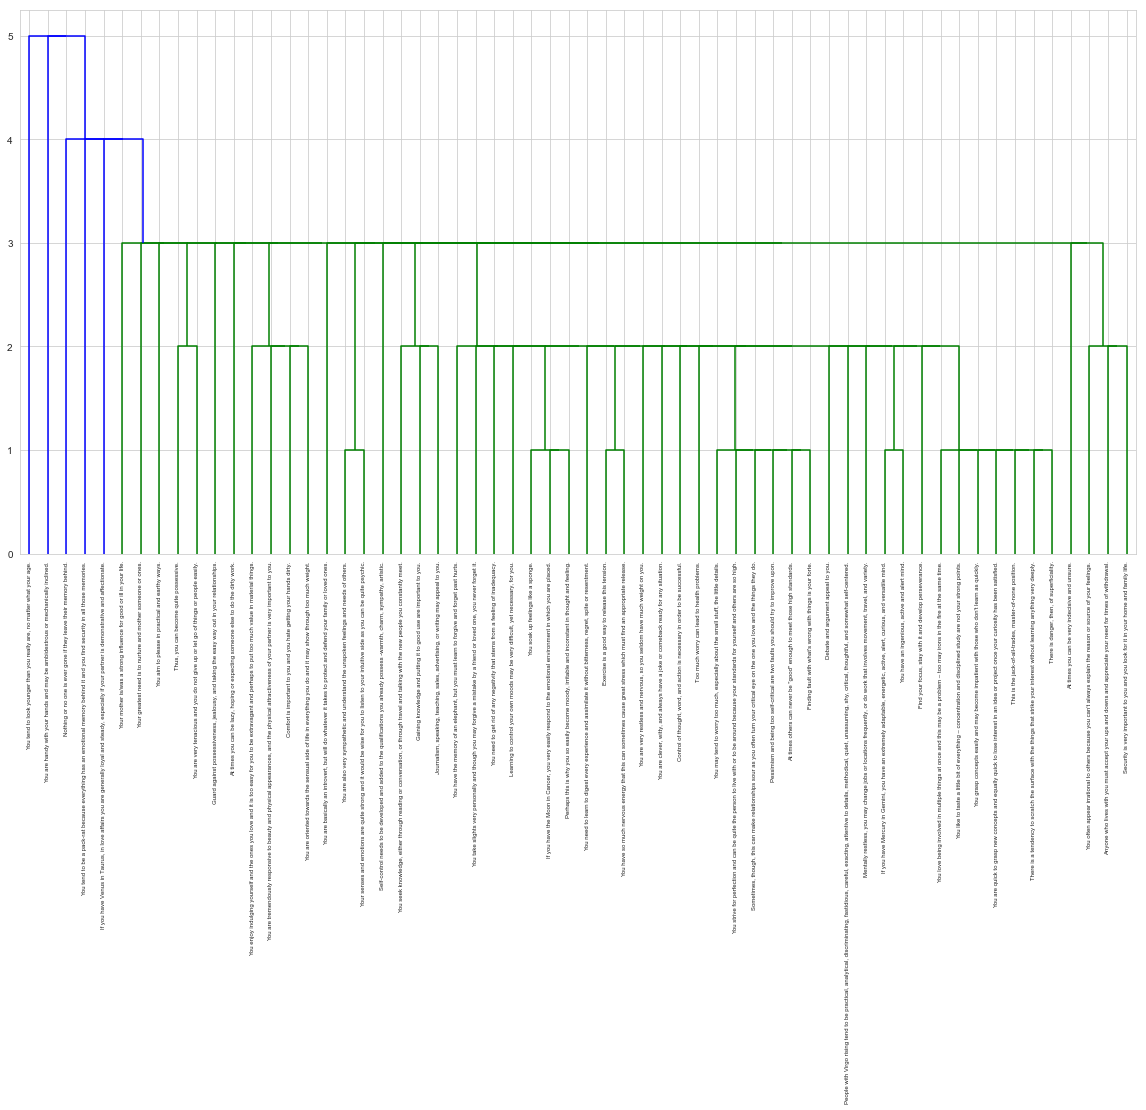

In [29]:
dendrogram(linkage_arr,
            orientation='top',
            labels=df_piv.index.values,
            distance_sort='descending',
            show_leaf_counts=True)

In [65]:
sil_scores = []
for i in range(2, len(dist_mat)):
    clusters = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage='single')
    clusters.fit_predict(dist_mat)

    # use metric to measure/compare goodness of clusters based on internal coherence and 
    # external coupling.
    # consider Dunn index. maximise the Dunn index.
    # or consider average sillhouette width (maximise). available in sklearn.
    from sklearn.metrics import silhouette_score

    silhouette_avg = silhouette_score(dist_mat, clusters.labels_, metric='precomputed')
    sil_scores.append(silhouette_avg)
    print(i, ": ", silhouette_avg)

2 :  0.05701149425287356
3 :  0.05801169590643274
4 :  0.05558350401092337
5 :  0.05636580948931547
6 :  0.053959792742581524
7 :  0.047865250450840134
8 :  0.009377639039746376
9 :  0.0031884642610394117
10 :  0.012866546390124306
11 :  0.01183734764900544
12 :  0.009284312648676485
13 :  0.035419109151031775
14 :  0.03241757138705969
15 :  0.04776637964863575
16 :  0.042015619515730344
17 :  0.046445590246123276
18 :  0.04924042665764425
19 :  0.016851602996544313
20 :  -0.002824322929381612
21 :  -0.007020993493191892
22 :  -0.008949160998564961
23 :  -0.01450471655412051
24 :  -0.04812954660922455
25 :  -0.05736326308432034
26 :  -0.06426947174947492
27 :  -0.07005691828931519
28 :  -0.09365643030027647
29 :  -0.10532692716487749
30 :  -0.04782761043353115
31 :  -0.05087127354350925
32 :  -0.01842502891139269
33 :  -0.02013058498479759
34 :  -0.02768694677891489
35 :  -0.019969423592859328
36 :  -0.017481517439013723
37 :  0.06626595766218407
38 :  0.07359525484525484
39 :  0.08552

In [80]:
sil_scores_arr = np.asarray(sil_scores)
print('max avg silhouette score: ', sil_scores_arr.max())
optimal_k = np.where(sil_scores_arr == sil_scores_arr.max())[0][0] + 2
print('nclusters w max avg silhouette score: ', optimal_k)

max avg silhouette score:  0.12454834054834055
nclusters w max avg silhouette score:  41


In [100]:
clusters = AgglomerativeClustering(n_clusters=optimal_k, affinity='precomputed', linkage='single')
clusters.fit_predict(dist_mat)
for i in range(clusters.n_clusters_):
    indices = np.where(clusters.labels_ == i)[0]
    
    print(f'cluster {i} (size {len(indices)}):')
    print(indices)
    for idx in indices:
        display(df_piv.index[idx])
    print('\n')

cluster 0 (size 8):
[ 8 25 26 27 36 41 45 46]


'Find your focus, stay with it and develop perseverance.'

'There is a tendency to scratch the surface with the things that strike your interest without learning anything very deeply.'

'There is danger, then, of superficiality.'

'This is the jack-of-all-trades, master-of-none position.'

'You are quick to grasp new concepts and equally quick to lose interest in an idea or project once your curiosity has been satisfied.'

"You grasp concepts easily and may become impatient with those who don't learn as quickly."

'You like to taste a little bit of everything – concentration and disciplined study are not your strong points.'

'You love being involved in multiple things at once and this may be a problem – too may irons in the fire at the same time.'



cluster 1 (size 3):
[ 0 22 50]


'Anyone who lives with you must accept your ups and downs and appreciate your need for times of withdrawal.'

'Security is very important to you and you look for it in your home and family life.'

"You often appear irrational to others because you can't always explain the reason or source of your feelings."



cluster 2 (size 2):
[31 59]


'You are also very sympathetic and understand the unspoken feelings and needs of others.'

'Your senses and emotions are quite strong and it would be wise for you to listen to your intuitive side as you can be quite psychic.'



cluster 3 (size 2):
[ 7 43]


'Exercise is a good way to release this tension.'

'You have so much nervous energy that this can sometimes cause great stress which must find an appropriate release.'



cluster 4 (size 2):
[12 42]


'If you have Mercury in Gemini, you have an extremely adaptable, energetic, active, alert, curious, and versatile mind.'

'You have an ingenious, active and alert mind.'



cluster 5 (size 1):
[58]


'Your mother is/was a strong influence for good or ill in your life.'



cluster 6 (size 3):
[14 20 52]


'If you have the Moon in Cancer, you very easily respond to the emotional environment in which you are placed.'

'Perhaps this is why you so easily become moody, irritable and inconstant in thought and feeling.'

'You soak up feelings like a sponge.'



cluster 7 (size 1):
[56]


'You tend to look younger than you really are, no matter what your age.'



cluster 8 (size 6):
[ 1  9 21 24 47 53]


'At times others can never be "good" enough to meet those high standards.'

"Finding fault with what's wrong with things is your forte."

'Pessimism and being too self-critical are two faults you should try to improve upon.'

'Sometimes, though, this can make relationships sour as you often turn your critical eye on the one you love and the things they do.'

'You may tend to worry too much, especially about the small stuff, the little details.'

'You strive for perfection and can be quite the person to live with or to be around because your standards for yourself and others are so high.'



cluster 9 (size 1):
[57]


'Your greatest need is to nurture and mother someone or ones.'



cluster 10 (size 1):
[37]


'You are tremendously responsive to beauty and physical appearances, and the physical attractiveness of your partner is very important to you.'



cluster 11 (size 1):
[51]


'You seek knowledge, either through reading or conversation, or through travel and talking with the new people you constantly meet.'



cluster 12 (size 1):
[54]


'You take slights very personally and though you may forgive a mistake by a friend or loved one, you never forget it.'



cluster 13 (size 1):
[39]


'You are very tenacious and you do not give up or let go of things or people easily.'



cluster 14 (size 1):
[49]


'You need to learn to digest every experience and assimilate it without bitterness, regret, spite or resentment.'



cluster 15 (size 1):
[38]


'You are very restless and nervous, so you seldom have much weight on you.'



cluster 16 (size 1):
[33]


'You are clever, witty, and always have a joke or comeback ready for any situation.'



cluster 17 (size 1):
[35]


'You are oriented towards the sensual side of life in everything you do and it may show through too much weight.'



cluster 18 (size 1):
[19]


'People with Virgo rising tend to be practical, analytical, discriminating, fastidious, careful, exacting, attentive to details, methodical, quiet, unassuming, shy, critical, thoughtful, and somewhat self-centered.'



cluster 19 (size 1):
[55]


'You tend to be a pack-rat because everything has an emotional memory behind it and you find security in all those memories.'



cluster 20 (size 1):
[40]


'You enjoy indulging yourself and the ones you love and it is too easy for you to be extravagant and perhaps to put too much value in material things.'



cluster 21 (size 1):
[11]


'Guard against possessiveness, jealousy, and taking the easy way out in your relationships.'



cluster 22 (size 1):
[4]


'Comfort is important to you and you hate getting your hands dirty.'



cluster 23 (size 1):
[2]


'At times you can be lazy, hoping or expecting someone else to do the dirty work.'



cluster 24 (size 1):
[10]


'Gaining knowledge and putting it to good use are important to you.'



cluster 25 (size 1):
[13]


'If you have Venus in Taurus, in love affairs you are generally loyal and steady, especially if your partner is demonstrative and affectionate.'



cluster 26 (size 1):
[44]


'You have the memory of an elephant, but you must learn to forgive and forget past hurts.'



cluster 27 (size 1):
[32]


'You are basically an introvert, but will do whatever it takes to protect and defend your family or loved ones.'



cluster 28 (size 1):
[16]


'Learning to control your own moods may be very difficult, yet necessary, for you.'



cluster 29 (size 1):
[34]


'You are handy with your hands and may be ambidextrous or mechanically inclined.'



cluster 30 (size 1):
[48]


'You need to get rid of any negativity that stems from a feeling of inadequacy.'



cluster 31 (size 1):
[18]


'Nothing or no one is ever gone if they leave their memory behind.'



cluster 32 (size 1):
[23]


'Self-control needs to be developed and added to the qualifications you already possess -warmth, charm, sympathy, artistic.'



cluster 33 (size 1):
[15]


'Journalism, speaking, teaching, sales, advertising, or writing may appeal to you.'



cluster 34 (size 1):
[5]


'Control of thought, word, and action is necessary in order to be successful.'



cluster 35 (size 1):
[29]


'Too much worry can lead to health problems.'



cluster 36 (size 1):
[30]


'You aim to please in practical and earthy ways.'



cluster 37 (size 1):
[3]


'At times you can be very indecisive and unsure.'



cluster 38 (size 1):
[6]


'Debate and argument appeal to you.'



cluster 39 (size 1):
[17]


'Mentally restless, you may change jobs or locations frequently, or do work that involves movement, travel, and variety.'



cluster 40 (size 1):
[28]


'Thus, you can become quite possessive.'